<h1 align="center">ЧАСТЬ 3</h1>
<h1 align="center">Training and Development of Different LSTM Models</h1> 

Для начала импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense
from keras.models import load_model
from keras.layers.core import Dropout

Также давайте напишем стиль для выравнивания по середине всех графиков, изображений и т.д.:

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h2 align="center">Подготовка входных данных</h2> 

Во-первых, мы загрузим образцы данных, которые мы обработали в первой части:

In [4]:
with open('documents.pql', 'rb') as f:
     docs = pickle.load(f)

In [5]:
import random

pos = [doc for doc in docs if doc[1] == "pos"][:15000]
neg = [doc for doc in docs if doc[1] == "neg"][:15000]

docs = pos + neg
random.shuffle(docs)

In [6]:
print("Number of documents:", len(docs))

Number of documents: 30000


Модель Google Word2Vec очень сложна для обработки с оперативной памятью настольного компьютера, поэтому мы будем использовать модель меньшего размера, а именно GloVe, модель содержит 400000 слов, таким образом, мы получим матрицу встраивания размером 400000 x 100, которая содержит все значения векторов слов.

Вы можете скачать модель [здесь](https://www.kaggle.com/datasets/anindya2906/glove6b?select=glove.6B.100d.txt ).

In [7]:
model = word2vec.KeyedVectors.load_word2vec_format('glove.6B.100d.w2vformat.txt', binary=False)

Теперь давайте составим список всех слов из нашего словаря:

In [8]:
words = list(model.index_to_key)

Просто чтобы убедиться, что все загружено правильно, мы можем посмотреть на размеры списка словарей и матрицы встраивания:

In [9]:
print("Total words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

Total words: 400000 

Word-Vectors shape: (400000, 100)


Форма нашей выборки для обучения будет `(H, N, 100)`, где:
* `H` - количество выборок;
* `N` - количество слов в каждом предложении;
* `100` - размерность каждого слова.

Давайте проанализируем, сколько слов обычно встречается в отзывах:

In [10]:
max_word, min_word = 0, 100
word50, word100, word200, word300, word400  = 0, 0, 0, 0, 0
reviews_len = []

for review, state in docs:
    reviews_len.append(len(review))

    if len(review) > max_word: max_word = len(review)
    if len(review) < min_word: min_word = len(review)

    if len(review) > 50: word50 += 1
    if len(review) > 100: word100 += 1
    if len(review) > 200: word200 += 1
    if len(review) > 300: word300 += 1
    if len(review) > 400: word400 += 1
    
print("Average number of words in the review:", int(sum(reviews_len)/len(reviews_len)))
print("\nMaximum review length:", max_word, "\nMinimum review length:", min_word)
print("\nReview with more than 50 words:", word50, 
      "\nReview with more than 100 words:", word100,
      "\nReview with more than 200 words:", word200, 
      "\nReview with more than 300 words:", word300,
      "\nReview with more than 400 words:", word400)

Average number of words in the review: 46

Maximum review length: 2376 
Minimum review length: 1

Review with more than 50 words: 8319 
Review with more than 100 words: 2790 
Review with more than 200 words: 693 
Review with more than 300 words: 225 
Review with more than 400 words: 98


Визуализируем частоту употребления слов в обзоре:

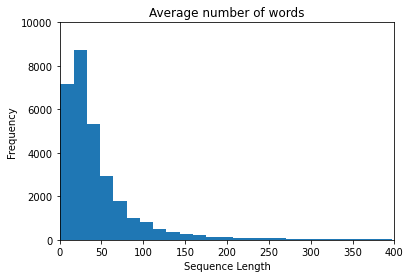

In [11]:
plt.hist(reviews_len, bins=150)
plt.axis([0, 400, 0, 10000])
plt.ylabel('Frequency')
plt.xlabel('Sequence Length');
plt.title("Average number of words");

Наша следующая функция `fix_review_len()` выполнит полезную работу, эта функция предназначена для фиксации размера отзывов до фиксированного размера, чтобы передавать их в нейронную сеть с отзывами определенной длины. Отзывы, длина которых меньше фиксированной, будут увеличены на нули. Этот процесс не влияет на алгоритм, и обзоры, длина которых превышает указанную, будут обрезаны.

In [12]:
def fix_review_len(review, length):
    if len(review) > length:
        review = review[:length]
    elif len(review) < length:
        for i in range(length - len(review)):
            zeros = [0] * 100
            review.append(zeros)
    return review

example = [3, 1, 2, 4, 5]
example = fix_review_len(example, 7)
print(example) 

[3, 1, 2, 4, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


Теперь давайте немного улучшим нашу функцию `sent_embed()` из предыдущей части, а затем обновим наш набор данных векторами слов.

Основываясь на данных гистограммы, а также на среднем количестве слов в файлах, мы можем с уверенностью сказать, что большинство отзывов будут содержать менее 100 слов, что является максимальным значением длины последовательности, которое мы установили.

In [13]:
def sent_embed(words, docs):
    x_sent_embed, y_sent_embed = [], [] 
    
    max_seq_len = 100
    
    # восстановим вложение каждого предложения со средним значением вектора, который его содержит, 
    # sent - предложение, state - состояние предложения (pos/neg)
    for sent, state in docs:
        # среднее вложение всех слов в предложение
        sent_embed = []
        for word in sent:
            try:
                # если слово присутствует в словаре - добавим его векторное представление
                sent_embed.append(model[word])
            except KeyError:
                # если слово отсутствует в словаре - добавим нулевой вектор
                sent_embed.append([0] * 100)
        
        # добавим вектор предложения в список
        sent_embed = fix_review_len(sent_embed, max_seq_len)
        x_sent_embed.append(sent_embed)
        
        # добавим метку в y_sent_embed
        if state == 'pos': y_sent_embed.append(1)
        elif state == 'neg': y_sent_embed.append(0)
            
    return x_sent_embed, y_sent_embed

In [14]:
x, y = sent_embed(words, docs)

In [15]:
x = np.array(x)
print("Shape of X:", x.shape)

Shape of X: (30000, 100, 100)


<h3 align="center">Разобъем текстовый корпус</h3>

Теперь, для дальнейшей работы, мы разделим наш корпус на наборы для обучения, тестирования и разработки:

In [16]:
from sklearn.model_selection import train_test_split

# обучающая / тестовая
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

# обучающая / валидационная
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [ ]:
print('Length of x_train:', len(x_train), '| Length of y_train:', len(y_train))
print('Length of x_test:  ', len(x_test), '| Length of y_test: ', len(y_test))
print('Length of x_val:   ', len(x_val), '| Length of y_val:  ', len(y_val))

Length of x_train: 21675 | Length of y_train: 21675
Length of x_test:   4500 | Length of y_test:  4500
Length of x_val:    3825 | Length of y_val:   3825


In [ ]:
print("Shape of x_train set:", x_train.shape)

Shape of x_train set: (21675, 100, 100)


<h2 align="center">Модель LSTM (оптимизатор стохастического градиентного спуска, SGD)</h2>

Любая рекуррентная нейронная сеть имеет форму цепочки повторяющихся модулей нейронной сети. В обычной RNN структура одного такого модуля очень проста, например, он может представлять собой один слой с функцией активации tanh (гиперболический тангенс).
Структура LSTM также напоминает цепочку, но модули выглядят иначе. Вместо одного слоя нейронной сети они содержат целых четыре, и эти слои взаимодействуют специальным образом:

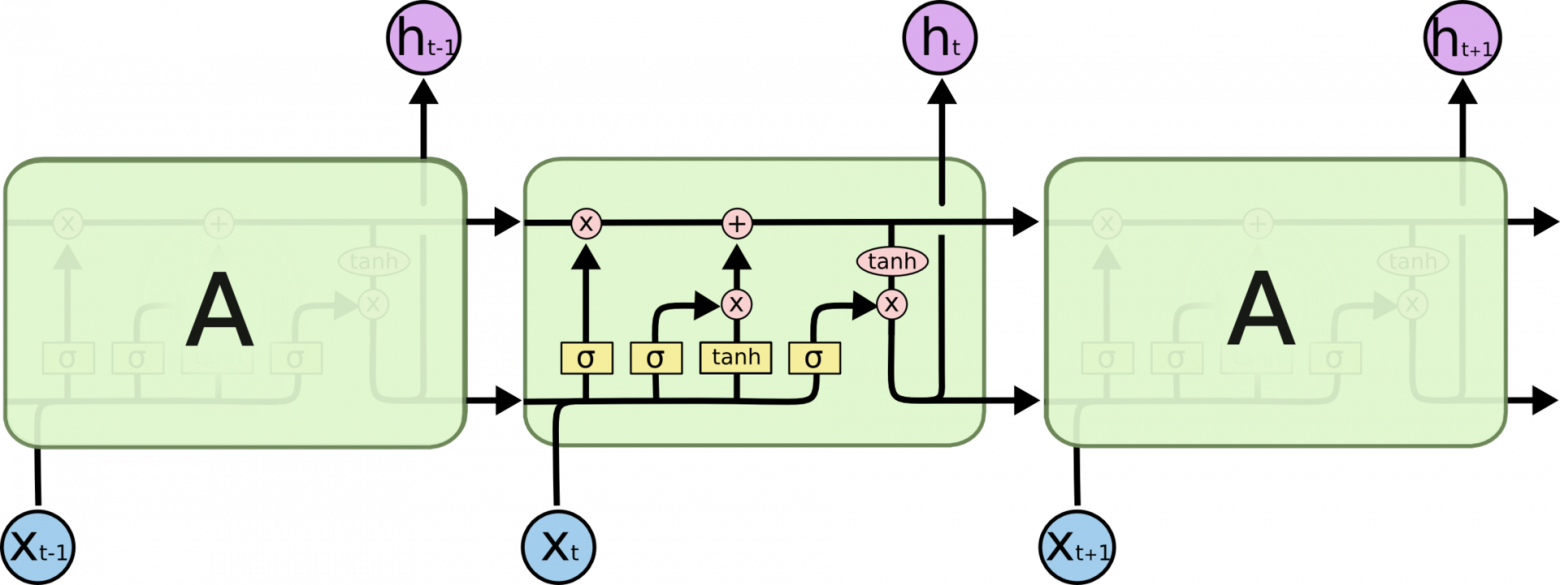


Преимущество Keras заключается в том, что он построен поверх символьных математических библиотек, таких как TensorFlow и Theano, для быстрых и эффективных вычислений. Это необходимо для работы с большими нейронными сетями.

Недостатком использования этих эффективных библиотек является то, что вы должны заранее и навсегда определить объем ваших данных. В частности, размер пакета.

Нейронные сети обучаются с использованием алгоритма оптимизации стохастического градиентного спуска.

Данный алгоритм включает в себя использование текущего состояния модели для составления прогноза, сравнение прогноза с ожидаемыми значениями и использование разницы в качестве оценки градиента ошибки. Этот градиент ошибки затем используется для обновления весовых коэффициентов модели, и процесс повторяется.

Градиент ошибки является статистической оценкой. Чем больше обучающих примеров используется в оценке, тем более точной будет эта оценка и тем больше вероятность того, что веса сети будут скорректированы таким образом, чтобы улучшить точность модели. Улучшенная оценка градиента ошибки достигается за счет необходимости использовать модель для получения гораздо большего количества прогнозов, прежде чем можно будет рассчитать оценку, и, в свою очередь, обновить весовые коэффициенты.

С другой стороны, использование меньшего количества примеров приводит к менее точной оценке градиента ошибки, который сильно зависит от конкретных используемых обучающих примеров.

Это приводит к зашумленной оценке, которая, в свою очередь, приводит к зашумленным обновлениям весов модели, например, ко многим обновлениям с, возможно, совершенно разными оценками градиента ошибки. Тем не менее, эти шумные обновления могут привести к более быстрому обучению, а иногда и к более надежной модели.

Количество обучающих примеров, используемых при оценке градиента ошибки, является гиперпараметром для алгоритма обучения, называемым “размером пакета”, или просто “пакетом”.

Размер пакета, равный 32, означает, что 32 выборки из обучающего набора данных будут использованы для оценки градиента ошибки до обновления весовых коэффициентов модели. Одна эпоха обучения означает, что алгоритм обучения выполнил один проход по набору обучающих данных, где примеры были разделены на случайно выбранные группы “размера пакета”.

Исторически сложилось так, что алгоритм обучения, в котором размер пакета устанавливается равным общему количеству обучающих примеров, называется “пакетный градиентный спуск”, а алгоритм обучения, в котором размер пакета устанавливается равным 1 обучающему примеру, называется “стохастический градиентный спуск” или “онлайн-градиентный спуск”.

Конфигурация размера пакета где-либо посередине (например, больше 1 примера и меньше количества примеров в обучающем наборе данных) называется “мини-пакетный градиентный спуск”.

  - **Пакетный градиентный спуск**. Размер пакета устанавливается равным общему количеству примеров в обучающем наборе данных.
  - **Стохастический градиентный спуск**. Размер пакета установлен равным единице.
  - **Градиентный спуск мини-партии**. Размер пакета устанавливается равным более чем одному и меньше общего количества примеров в обучающем наборе данных.
Для краткости этот алгоритм часто называют стохастическим градиентным спуском независимо от размера пакета. Учитывая, что для обучения нейронных сетей глубокого обучения часто используются очень большие наборы данных, размер пакета редко устанавливается равным размеру обучающего набора данных.

Меньшие размеры партий используются по двум основным причинам:

  - Меньшие размеры пакетов создают помехи, обеспечивая эффект упорядочивания и меньшую ошибку обобщения.
  - Меньшие размеры пакетов облегчают размещение обучающих данных объемом в один пакет в памяти (например, при использовании графического процессора).
Третья причина заключается в том, что размер пакета часто устанавливается на что-то небольшое, например на 32 примера, и не настраивается специалистом. Небольшие партии, такие как 32 штуки, как правило, работают хорошо.

Тем не менее, размер пакета влияет на скорость обучения модели и стабильность процесса обучения. Это важный гиперпараметр, который должен быть хорошо понят и настроен специалистом по глубокому обучению.

<h3 align="center">Определение и создание нейросети</h3>

Сеть имеет один вход, скрытый уровень со 128 блоками и выходной уровень с 1 блоком.

Для решения этой задачи используется функция оптимизации среднеквадратичной ошибки с использованием эффективного алгоритма оптимизации ADAM.

Итак, теперь давайте настроим и создадим сеть:

In [ ]:
# определим параметры сети
n_neurons = 128
n_epoch = 20
n_batch = 1

# создадим сеть, дополнив LSTM-слой полносвязным:
model_batch = Sequential()
model_batch.add(LSTM(n_neurons, input_shape=(x.shape[1], x.shape[2])))
model_batch.add(Dense(1, activation='sigmoid'))
model_batch.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model_batch.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 117,377
Trainable params: 117,377
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_batch_hist = model_batch.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch, verbose=1, shuffle=False)

Epoch 1/20
21675/21675 [==============================] - 814s 37ms/step - loss: 0.2422 - binary_accuracy: 0.5394
Epoch 2/20
21675/21675 [==============================] - 801s 37ms/step - loss: 0.1546 - binary_accuracy: 0.7764
Epoch 3/20
21675/21675 [==============================] - 809s 37ms/step - loss: 0.1286 - binary_accuracy: 0.8216
Epoch 4/20
21675/21675 [==============================] - 810s 37ms/step - loss: 0.1063 - binary_accuracy: 0.8581
Epoch 5/20
21675/21675 [==============================] - 801s 37ms/step - loss: 0.0886 - binary_accuracy: 0.8845
Epoch 6/20
21675/21675 [==============================] - 787s 36ms/step - loss: 0.0765 - binary_accuracy: 0.9009
Epoch 7/20
21675/21675 [==============================] - 795s 37ms/step - loss: 0.0710 - binary_accuracy: 0.9109
Epoch 8/20
21675/21675 [==============================] - 792s 37ms/step - loss: 0.0651 - binary_accuracy: 0.9182
Epoch 9/20
21675/21675 [==============================] - 811s 37ms/step - loss: 0.0622 

In [ ]:
score_batch = model_batch.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(score_batch[1] * 100, 2)) + '%')

3825/3825 [==============================] - 33s 9ms/step - loss: 0.1648 - binary_accuracy: 0.7969

Model Accuracy: 79.69%


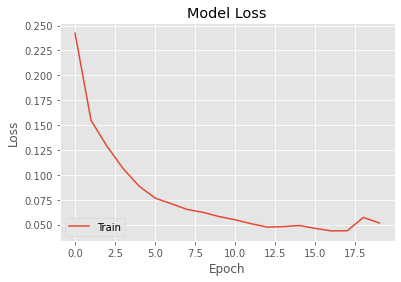

In [ ]:
plt.style.use('ggplot')
plt.plot(model_batch_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

Результаты хорошие, давайте сохраним эту модель и попробуем другой подход.

In [ ]:
model_batch.save('models/LSTM-Batch-Model.h5')  # save model
del model_batch  # удалим модель после сохранения

In [17]:
from keras.models import load_model

# возвращает скомпилированную модель, идентичную предыдущей
model_batch = load_model('models/LSTM-Batch-Model.h5')

Давайте проверим, все ли правильно:

In [21]:
score_batch = model_batch.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(score_batch[1] * 100, 2)) + '%')

30/30 [==============================] - 16s 397ms/step - loss: 0.0692 - binary_accuracy: 0.9182

Model Accuracy: 91.82%


<h2 align="center">Модель LSTM (мини-пакетный градиентный спуск)</h2>

Мини-пакетный градиентный спуск - это вариация алгоритма градиентного спуска, который разбивает обучающий набор данных на небольшие пакеты, которые используются для вычисления ошибки модели и обновления коэффициентов модели.

Мини-пакетный алгоритм - это наиболее удобный и широко используемый алгоритм, который дает точные и быстрые результаты, используя пакет из `m` обучающих примеров. В алгоритме mini batch вместо использования полного набора данных на каждой итерации мы используем набор обучающих примеров `m`, называемый batch, для вычисления градиента функции затрат. Обычные размеры мини-пакетов варьируются от 32 до 256 штук.

<h3 align="center">Определение и создание нейросети</h3>

Мы будем использовать сеть LSTM, рассчитанную на 20 эпох и с размером пакета = 128.

Для решения этой задачи используется функция оптимизации среднеквадратичной ошибки с использованием эффективного алгоритма оптимизации ADAM.

Итак, теперь давайте настроим и создадим сеть:

In [ ]:
# определим параметры сети
n_neurons = 128
n_epoch = 20
n_batch = 128

# создадим сеть, дополнив LSTM-слой полносвязным:
model_mini = Sequential()
model_mini.add(LSTM(n_neurons, input_shape=(x.shape[1], x.shape[2])))
model_mini.add(Dense(1, activation='sigmoid'))
model_mini.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model_mini.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 117,377
Trainable params: 117,377
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_mini_hist = model_mini.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch, verbose=1)

Epoch 1/20
170/170 [==============================] - 60s 338ms/step - loss: 0.2163 - binary_accuracy: 0.6496
Epoch 2/20
170/170 [==============================] - 57s 337ms/step - loss: 0.1772 - binary_accuracy: 0.7510
Epoch 3/20
170/170 [==============================] - 56s 330ms/step - loss: 0.1597 - binary_accuracy: 0.7737
Epoch 4/20
170/170 [==============================] - 56s 330ms/step - loss: 0.1473 - binary_accuracy: 0.7918
Epoch 5/20
170/170 [==============================] - 56s 332ms/step - loss: 0.1373 - binary_accuracy: 0.8092
Epoch 6/20
170/170 [==============================] - 57s 338ms/step - loss: 0.1310 - binary_accuracy: 0.8217
Epoch 7/20
170/170 [==============================] - 57s 335ms/step - loss: 0.1205 - binary_accuracy: 0.8371
Epoch 8/20
170/170 [==============================] - 57s 333ms/step - loss: 0.1133 - binary_accuracy: 0.8477
Epoch 9/20
170/170 [==============================] - 57s 336ms/step - loss: 0.1110 - binary_accuracy: 0.8543
Epoch 10/2

In [ ]:
model_mini_score = model_mini.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(model_mini_score[1] * 100, 2)) + '%')

30/30 [==============================] - 4s 127ms/step - loss: 0.1313 - binary_accuracy: 0.8327

Model Accuracy: 83.27%


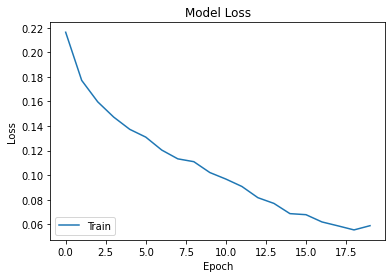

In [ ]:
plt.plot(model_mini_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

Это хорошие показатели для модели, мы можем ее использовать. Давайте сохраним нашу модель:

In [ ]:
model_mini.save('models/LSTM-Mini-Batch-Model.h5')  # save model
del model_mini  # delete existing model

In [22]:
# возвращает скомпилированную модель, идентичную предыдущей
model_mini = load_model('models/LSTM-Mini-Batch-Model.h5')

Проверим, все ли правильно:

In [23]:
model_mini_score = model_mini.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(model_mini_score[1] * 100, 2)) + '%')

30/30 [==============================] - 5s 131ms/step - loss: 0.0747 - binary_accuracy: 0.9067

Model Accuracy: 90.67%


<h2 align="center">Модель с несколькими LSTM-слоями</h2>

Теперь мы попробуем модель с 3-мя последовательными слоями LSTM:

In [ ]:
# задаем параметры сети
n_neurons = 100
n_epoch = 20
n_batch = 128

# создаем сеть
model3L = Sequential()

model3L.add(LSTM(n_neurons, return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model3L.add(LSTM(32, return_sequences=True))  # возвращает последовательность векторов размерности 32
model3L.add(LSTM(32))  # возвращает единственный вектор размерности 32

model3L.add(Dense(1, activation='sigmoid'))
model3L.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

print(model3L.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          80400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           17024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 105,777
Trainable params: 105,777
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model3L_hist = model3L.fit(x_train, np.asarray(y_train), batch_size=n_batch, epochs=n_epoch, verbose=1)

Epoch 1/20
170/170 [==============================] - 74s 399ms/step - loss: 0.2189 - binary_accuracy: 0.6408
Epoch 2/20
170/170 [==============================] - 69s 408ms/step - loss: 0.1775 - binary_accuracy: 0.7501
Epoch 3/20
170/170 [==============================] - 68s 398ms/step - loss: 0.1627 - binary_accuracy: 0.7672
Epoch 4/20
170/170 [==============================] - 73s 431ms/step - loss: 0.1502 - binary_accuracy: 0.7873
Epoch 5/20
170/170 [==============================] - 68s 403ms/step - loss: 0.1473 - binary_accuracy: 0.7971
Epoch 6/20
170/170 [==============================] - 70s 411ms/step - loss: 0.1373 - binary_accuracy: 0.8132
Epoch 7/20
170/170 [==============================] - 68s 403ms/step - loss: 0.1293 - binary_accuracy: 0.8238
Epoch 8/20
170/170 [==============================] - 68s 398ms/step - loss: 0.1225 - binary_accuracy: 0.8332
Epoch 9/20
170/170 [==============================] - 68s 401ms/step - loss: 0.1131 - binary_accuracy: 0.8470
Epoch 10/2

In [ ]:
model3L_score = model3L.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(model3L_score[1] * 100, 2)) + '%')

30/30 [==============================] - 6s 147ms/step - loss: 0.1419 - binary_accuracy: 0.8207

Model Accuracy: 82.07%


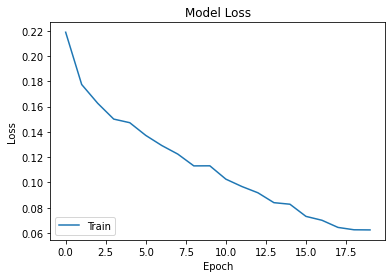

In [ ]:
plt.plot(model3L_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

Let's save our model:

In [ ]:
model3L.save('models/LSTM-3L-Model.h5')  # save model
del model3L  # удаляем старую модель

In [24]:
# возвращает скомпилированную модель, идентичную предыдущей
model3L = load_model('models/LSTM-3L-Model.h5')

Let's check if everything is correct:

In [25]:
model3L_score = model3L.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(model3L_score[1] * 100, 2)) + '%')

30/30 [==============================] - 6s 144ms/step - loss: 0.0740 - binary_accuracy: 0.9098

Model Accuracy: 90.98%


<h2 align="center">Двунаправленная LSTM</h2>

Двунаправленные LSTM являются расширением традиционных LSTM, которые могут повысить производительность модели при решении задач классификации последовательностей.
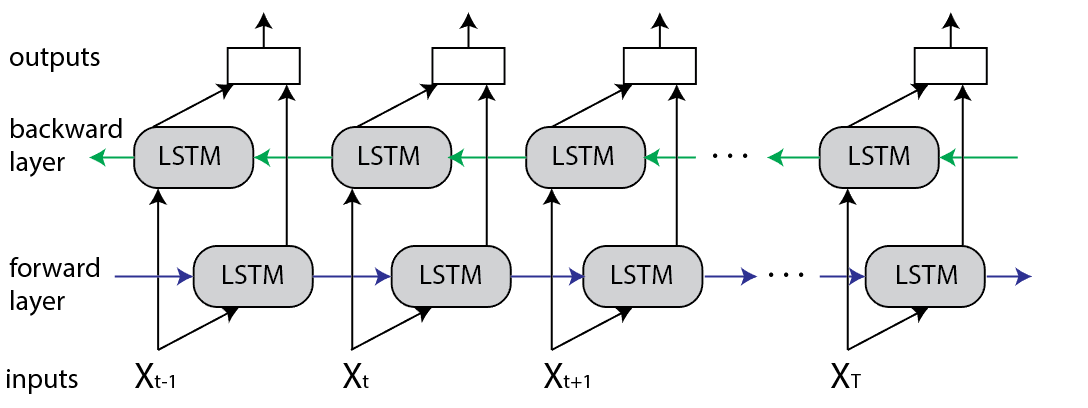
В задачах, где доступны все временные интервалы входной последовательности, двунаправленные LSTM обучают две вместо одной LSTM входной последовательности. Первый - для входной последовательности как есть, а второй - для обратной копии входной последовательности. Это может обеспечить дополнительный контекст для сети и привести к более быстрому и даже полному изучению проблемы.

Идея двунаправленных рекуррентных нейронных сетей (RNNS) проста.

Она включает в себя дублирование первого рекуррентного уровня в сети таким образом, что теперь существует два уровня бок о бок, затем предоставление входной последовательности как есть в качестве входных данных первому уровню и предоставление обратной копии входной последовательности второму.

In [ ]:
from keras.layers.core import Dropout
from keras.layers import Bidirectional

# задаем параметры сети
n_epoch = 20
n_batch = 64

# создаем сеть
model_Bi_LSTM = Sequential()
model_Bi_LSTM.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(x.shape[1], x.shape[2])))
model_Bi_LSTM.add(Bidirectional(LSTM(64)))
model_Bi_LSTM.add(Dropout(0.5))
model_Bi_LSTM.add(Dense(1, activation='sigmoid'))

# попробуем использовать разные оптимизаторы и разные конфигурации оптимизатора
model_Bi_LSTM.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])
print(model_Bi_LSTM.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 183,425
Trainable params: 183,425
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_Bi_LSTM_hist = model_Bi_LSTM.fit(x_train, np.asarray(y_train), epochs=n_epoch, batch_size=n_batch, verbose=1, validation_data=(x_val, np.asarray(y_val)))

Epoch 1/20
339/339 [==============================] - 133s 370ms/step - loss: 0.5575 - binary_accuracy: 0.7166 - val_loss: 0.5054 - val_binary_accuracy: 0.7537
Epoch 2/20
339/339 [==============================] - 125s 369ms/step - loss: 0.4757 - binary_accuracy: 0.7772 - val_loss: 0.4474 - val_binary_accuracy: 0.7856
Epoch 3/20
339/339 [==============================] - 123s 363ms/step - loss: 0.4388 - binary_accuracy: 0.7957 - val_loss: 0.4401 - val_binary_accuracy: 0.7864
Epoch 4/20
339/339 [==============================] - 121s 357ms/step - loss: 0.4008 - binary_accuracy: 0.8215 - val_loss: 0.4184 - val_binary_accuracy: 0.8026
Epoch 5/20
339/339 [==============================] - 121s 356ms/step - loss: 0.3726 - binary_accuracy: 0.8356 - val_loss: 0.3843 - val_binary_accuracy: 0.8303
Epoch 6/20
339/339 [==============================] - 120s 355ms/step - loss: 0.3490 - binary_accuracy: 0.8478 - val_loss: 0.3800 - val_binary_accuracy: 0.8340
Epoch 7/20
339/339 [====================

In [ ]:
model_Bi_LSTM_score = model_Bi_LSTM.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(model_Bi_LSTM_score[1] * 100, 2)) + '%')

60/60 [==============================] - 6s 105ms/step - loss: 0.7010 - binary_accuracy: 0.8342

Model Accuracy: 83.42%


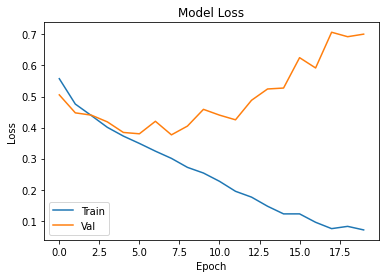

In [ ]:
plt.plot(model_Bi_LSTM_hist.history['loss'])
plt.plot(model_Bi_LSTM_hist.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')

plt.show()

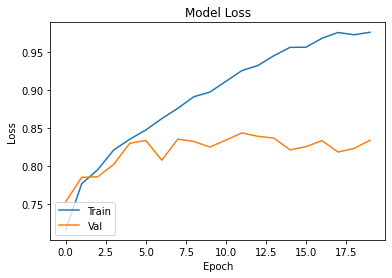

In [ ]:
plt.plot(model_Bi_LSTM_hist.history['binary_accuracy'])
plt.plot(model_Bi_LSTM_hist.history['val_binary_accuracy'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')

plt.show()

Сохраним модель:

In [ ]:
model_Bi_LSTM.save('models/LSTM-Bi-Model.h5')  # записываем модель в файл
del model_Bi_LSTM  # удаляем предыдущую

In [26]:
# возвращаем скомпилированную модель, идентичную предыдущей
model_Bi_LSTM = load_model('models/LSTM-Bi-Model.h5')

In [27]:
model_Bi_LSTM_score = model_Bi_LSTM.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(model_Bi_LSTM_score[1] * 100, 2)) + '%')

60/60 [==============================] - 7s 93ms/step - loss: 0.2522 - binary_accuracy: 0.9331

Model Accuracy: 93.31%


<h2 align="center">Сверточная сеть + LSTM</h2>

Этот подход полностью основан на [этой работе](https://www.aclweb.org/anthology/P16-2037.pdf ). Как указано в работе:

<cite>
    
    Анализ пространственных настроений направлен на распознавание непрерывных числовых значений в нескольких измерениях, таких как валентно-зависимое пространство (VA). 
    
    По сравнению с категориальным подходом, который фокусируется на классификации настроений, такой как бинарная классификация (т.е. положительная и отрицательная), многомерный подход может обеспечить более детальный анализ настроений. В этом исследовании предлагается региональная модель CNN-LSTM, состоящая из двух частей: региональной CNN и LSTM для прогнозирования рейтингов VA текстов. 
   
    В отличие от обычного CNN, который рассматривает весь текст в качестве входных данных, предлагаемый региональный CNN использует отдельное предложение в качестве области, разделяя входной текст на несколько областей таким образом, что полезная эмоциональная информация в каждой области может быть извлечена и взвешена в соответствии с их вкладом в прогнозирование VA. Такая региональная информация последовательно интегрируется по регионам с использованием LSTM для прогнозирования VA. 

</cite>

Короче говоря, словесные векторы словарного запаса обучаются на основе большого корпуса с использованием инструментария word2vec. Для каждого заданного текста региональная модель CNN использует предложение в качестве региона, чтобы разделить текст на R-домены, то есть r1, ..., ri rj, rk, ..., rR. В каждой области полезные аффективные функции могут быть удалены, когда векторы слов последовательно проходят через сверточный слой и слой максимального объединения. Затем такие локальные (региональные) признаки последовательно интегрируются между регионами с использованием LSTM для построения текстового вектора для прогнозирования VA.

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Bidirectional

# задаем параметры сети
n_epoch = 20
n_batch = 128

# формируем сеть
model_CNN_LSTM = Sequential()

model_CNN_LSTM.add(Conv1D(filters=128, kernel_size=4, input_shape=(x.shape[1], x.shape[2]), padding='same', activation='relu'))
model_CNN_LSTM.add(MaxPooling1D(pool_size=3))
model_CNN_LSTM.add(Bidirectional(LSTM(64, return_sequences = True)))
model_CNN_LSTM.add(LSTM(32, recurrent_dropout = 0.4))
model_CNN_LSTM.add(Dropout(0.2))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))

model_CNN_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

print(model_CNN_LSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 128)          51328     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 128)          0         
 )                                                               
                                                                 
 bidirectional_2 (Bidirectio  (None, 33, 128)          98816     
 nal)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
model_CNN_LSTM_hist = model_CNN_LSTM.fit(x_train, np.asarray(y_train), epochs=n_epoch, batch_size=n_batch)

Epoch 1/20
170/170 [==============================] - 50s 252ms/step - loss: 0.5844 - binary_accuracy: 0.6836
Epoch 2/20
170/170 [==============================] - 43s 254ms/step - loss: 0.4661 - binary_accuracy: 0.7814
Epoch 3/20
170/170 [==============================] - 43s 254ms/step - loss: 0.3921 - binary_accuracy: 0.8293
Epoch 4/20
170/170 [==============================] - 43s 253ms/step - loss: 0.3271 - binary_accuracy: 0.8630
Epoch 5/20
170/170 [==============================] - 43s 252ms/step - loss: 0.2834 - binary_accuracy: 0.8844
Epoch 6/20
170/170 [==============================] - 43s 253ms/step - loss: 0.2306 - binary_accuracy: 0.9112
Epoch 7/20
170/170 [==============================] - 44s 257ms/step - loss: 0.1780 - binary_accuracy: 0.9364
Epoch 8/20
170/170 [==============================] - 43s 255ms/step - loss: 0.1597 - binary_accuracy: 0.9436
Epoch 9/20
170/170 [==============================] - 44s 256ms/step - loss: 0.1218 - binary_accuracy: 0.9592
Epoch 10/2

In [ ]:
model_CNN_LSTM_score = model_CNN_LSTM.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:",str(round(model_CNN_LSTM_score[1] * 100, 2)) + '%')

30/30 [==============================] - 4s 81ms/step - loss: 0.8386 - binary_accuracy: 0.8188

Model Accuracy: 81.88%


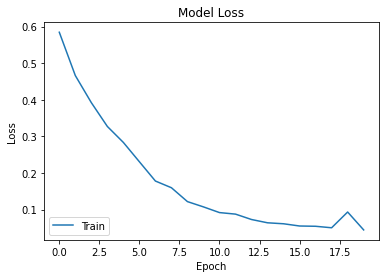

In [ ]:
plt.plot(model_CNN_LSTM_hist.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower left')

plt.show()

Let's save our model:

In [ ]:
model_CNN_LSTM.save('models/LSTM-CNN-Model.h5')  # сохраняем модель
del model_CNN_LSTM  # удаляем существующую сеть

In [28]:
# возвращает скомпилированную модель, идентичную предыдущей
model_CNN_LSTM = load_model('models/LSTM-CNN-Model.h5')

In [29]:
model_CNN_LSTM_score = model_CNN_LSTM.evaluate(x_val, np.asarray(y_val), batch_size=n_batch)
print("\nModel Accuracy:", str(round(model_CNN_LSTM_score[1] * 100, 2)) + '%')

30/30 [==============================] - 5s 75ms/step - loss: 0.2533 - binary_accuracy: 0.9448

Model Accuracy: 94.48%


<h2 align="center">Тестирование</h2>

Пока что с точки зрения точности лучшей моделью является модель LSTM с мини-пакетным градиентным спуском.

Давайте попробуем проверить тестовые данные на всех тестовых примерах, кроме одного, чтобы увидеть, может ли модель предсказать это:

In [ ]:
print("Length of test data (except 1):", len(x_test[:-1]))

Length of test data (except 1): 5781


In [ ]:
score_test = model_mini.evaluate(x_test[:-1], np.asarray(y_test[:-1]))
print(score_test)

181/181 [==============================] - 7s 35ms/step - loss: 0.1390 - binary_accuracy: 0.8324
[0.13903364539146423, 0.8323819637298584]


In [ ]:
score_test_one = model_CNN_LSTM.evaluate(x_test[-1:], np.asarray(y_test[-1:]))
print(score_test_one)

1/1 [==============================] - 1s 583ms/step - loss: 0.0084 - binary_accuracy: 1.0000
[0.008366141468286514, 1.0]


In [ ]:
predict_test = (model_CNN_LSTM.predict(x_test[:-1]) > 0.5).astype("int32")
print(predict_test)

[[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


In [ ]:
predict_test_one = (model_CNN_LSTM.predict(x_test[-1:]) > 0.5).astype("int32")

In [ ]:
print("Predicted value:", predict_test_one[0][0], "\nActual value:", y_test[-1:][0])

Predicted value: 1 
Actual value: 1


Предсказание работает отлично, теперь давайте визуализируем данные.

<h2 align="center">Визуализация отчета по классификации</h2>

Нам понадобится наш метод из предыдущей части, чтобы визуализировать наши данные, поэтому мы будем использовать их сейчас.

In [30]:
def plot_classification_report(classification_report, title='Classification Report', cmap='RdBu'):
    
    lines = classification_report.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    
    for line in lines[2 : (len(lines) - 5)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [31]:
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle='dashed', linewidths=0.2, cmap=cmap)

    # поставим основные галочки в середине каждой ячейки
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # установим метки для отметок
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # установим метки осей x/y
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # удалим последний пустой столбец
    plt.xlim( (0, AUC.shape[1]) )

    # выключим отметки
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False

    # добавим легенду цветов
    plt.colorbar(c)

    # добавим текст в каждую ячейку
    show_val(c)

    # proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # установим размер
    fig = plt.gcf()
    fig.set_size_inches(cm_to_inch(figure_width, figure_height))

In [32]:
def show_val(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

In [33]:
def cm_to_inch(*dim):
    inch = 2.54
    return tuple(i/inch for i in dim[0]) if type(dim[0]) == tuple else tuple(i/inch for i in dim)

<h2 align="center">Сравнение модели</h2> 

Полезным инструментом при прогнозировании вероятности бинарного результата является кривая рабочих характеристик приемника, или ROC-кривая.

Это график частоты ложных срабатываний (ось x) в сравнении с частотой истинных срабатываний (ось y) для ряда различных возможных пороговых значений в диапазоне от 0,0 до 1,0. Другими словами, он отображает частоту ложных срабатываний в зависимости от частоты попаданий.

Показатель истинно положительных результатов рассчитывается как количество истинно положительных результатов, деленное на сумму количества истинно положительных результатов и количества ложноотрицательных результатов. Он описывает, насколько хороша модель в прогнозировании положительного класса, когда фактический результат положительный.

Частота ложных срабатываний рассчитывается как количество ложноположительных срабатываний, деленное на сумму количества ложноположительных срабатываний и количества истинно отрицательных срабатываний.

Его также называют частотой ложных тревог, поскольку он суммирует, как часто прогнозируется положительный класс, когда фактический результат отрицательный.

Проще говоря:
* Меньшие значения по оси x графика указывают на меньшее количество ложноположительных срабатываний и большее количество истинно отрицательных.
* Большие значения по оси y графика указывают на более высокие истинные срабатывания и меньшие ложноотрицательные результаты.

Classification Report LSTM Stochastic Gradient Descent Model:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      2176
           1       0.92      0.90      0.91      2324

    accuracy                           0.91      4500
   macro avg       0.91      0.91      0.91      4500
weighted avg       0.91      0.91      0.91      4500



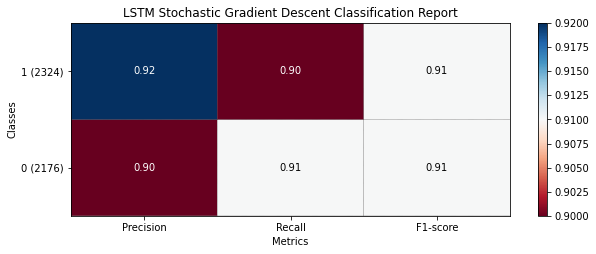

In [34]:
from sklearn.metrics import classification_report

batch_prediction = (model_batch.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Stochastic Gradient Descent Model:\n', classification_report(y_test, batch_prediction))

plot_classification_report(classification_report(y_test, batch_prediction), title='LSTM Stochastic Gradient Descent Classification Report', cmap='RdBu')

Classification Report LSTM Mini-Batch Model:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      2176
           1       0.94      0.90      0.92      2324

    accuracy                           0.92      4500
   macro avg       0.92      0.92      0.92      4500
weighted avg       0.92      0.92      0.92      4500



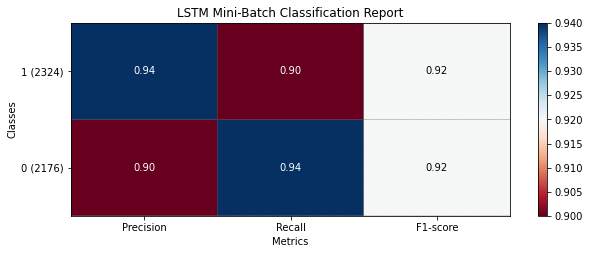

In [35]:
mini_prediction = (model_mini.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Mini-Batch Model:\n', classification_report(y_test, mini_prediction))

plot_classification_report(classification_report(y_test, mini_prediction), title='LSTM Mini-Batch Classification Report', cmap='RdBu')

Classification Report LSTM Stacked Layers Model:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      2176
           1       0.90      0.92      0.91      2324

    accuracy                           0.91      4500
   macro avg       0.91      0.91      0.91      4500
weighted avg       0.91      0.91      0.91      4500



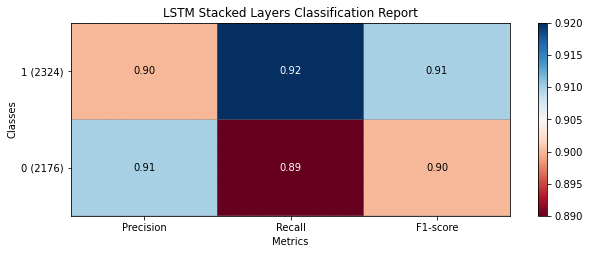

In [36]:
stack_layer_prediction = (model3L.predict(x_test) > 0.5).astype("int32")
print('Classification Report LSTM Stacked Layers Model:\n', classification_report(y_test, stack_layer_prediction))

plot_classification_report(classification_report(y_test, stack_layer_prediction), title='LSTM Stacked Layers Classification Report', cmap='RdBu')

Classification Report Bidirectional LSTM Model:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      2176
           1       0.92      0.96      0.94      2324

    accuracy                           0.94      4500
   macro avg       0.94      0.94      0.94      4500
weighted avg       0.94      0.94      0.94      4500



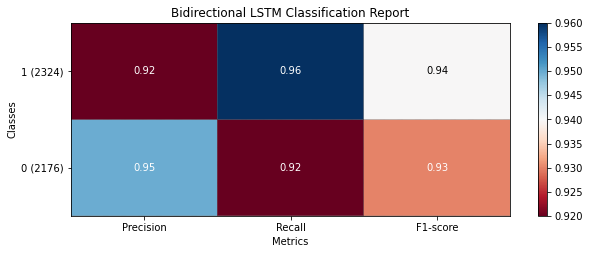

In [37]:
lstm_bi_prediction = (model_Bi_LSTM.predict(x_test) > 0.5).astype("int32")
print('Classification Report Bidirectional LSTM Model:\n', classification_report(y_test, lstm_bi_prediction))

plot_classification_report(classification_report(y_test, lstm_bi_prediction), title='Bidirectional LSTM Classification Report', cmap='RdBu')

Classification Report CNN + LSTM Model:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      2176
           1       0.96      0.93      0.94      2324

    accuracy                           0.94      4500
   macro avg       0.94      0.94      0.94      4500
weighted avg       0.94      0.94      0.94      4500



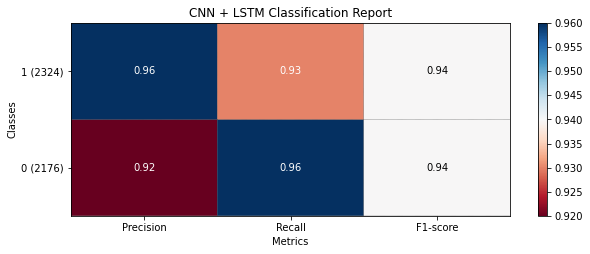

In [38]:
lstm_cnn_prediction = (model_CNN_LSTM.predict(x_test) > 0.5).astype("int32")
print('Classification Report CNN + LSTM Model:\n', classification_report(y_test, lstm_cnn_prediction))

plot_classification_report(classification_report(y_test, lstm_cnn_prediction), title='CNN + LSTM Classification Report', cmap='RdBu')

In [39]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

fprB, tprB, thresholdsB = metrics.roc_curve(y_test, model_batch.predict(x_test))
fprMB, tprMB, thresholdsMB = metrics.roc_curve(y_test, model_mini.predict(x_test))
fpr3L, tpr3L, thresholds3L = metrics.roc_curve(y_test, model3L.predict(x_test))
fprBi, tprBi, thresholdsBi = metrics.roc_curve(y_test, model_Bi_LSTM.predict(x_test))
fprCNN, tprCNN, thresholdsCNN = metrics.roc_curve(y_test, model_CNN_LSTM.predict(x_test))

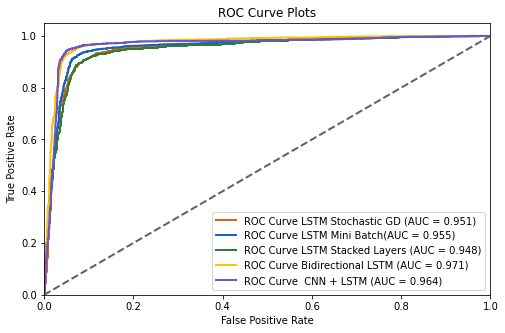

In [40]:
linewidth = 2
plt.figure(figsize=(8, 5))

plt.plot(fprB, tprB, color='#db6114', lw=linewidth, label='ROC Curve LSTM Stochastic GD (AUC = %0.3f)' % auc(fprB, tprB))
plt.plot(fprMB, tprMB, color='#1565c0', lw=linewidth, label='ROC Curve LSTM Mini Batch(AUC = %0.3f)' % auc(fprMB, tprMB))
plt.plot(fpr3L, tpr3L, color='#2e7d32', lw=linewidth, label='ROC Curve LSTM Stacked Layers (AUC = %0.3f)' % auc(fpr3L, tpr3L))
plt.plot(fprBi, tprBi, color='#ffc107', lw=linewidth, label='ROC Curve Bidirectional LSTM (AUC = %0.3f)' % auc(fprBi, tprBi))
plt.plot(fprCNN, tprCNN, color='#6557d2', lw=linewidth, label='ROC Curve  CNN + LSTM (AUC = %0.3f)' % auc(fprCNN, tprCNN))
plt.plot([0, 1], [0, 1], color='#616161', lw=linewidth, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Plots')
plt.legend(loc="lower right")

plt.show()

Как мы видим, все модели показывают примерно одинаковый результат, но пока лучшей является модель с наложенными слоями (90,4%), поэтому мы будем использовать ее.